### Load the data

In [1]:
import pandas as pd

df = pd.read_csv('data/us-insurance-data.csv')

Exploring the shape of the data

In [17]:
display(df.info())
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   float64
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(4), object(3)
memory usage: 73.3+ KB


None

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Check for missing values

In [2]:
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


### Handle missing values

In [3]:
from sklearn.impute import SimpleImputer

# For numerical columns, fill missing values with the median
numerical_cols = ['age', 'bmi', 'children']
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

### Convert categorical variables into numerical variables

In [4]:
categorical_cols = ['sex', 'smoker', 'region']
df.dropna(subset=categorical_cols, inplace=True)

# Drop rows where 'charges' is NaN
df.dropna(subset=['charges'], inplace=True)

# Verify that missing values have been handled
print("\nMissing values after handling missing values:")
print(df.isnull().sum())


Missing values after handling missing values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


### Plot the distribution of charges

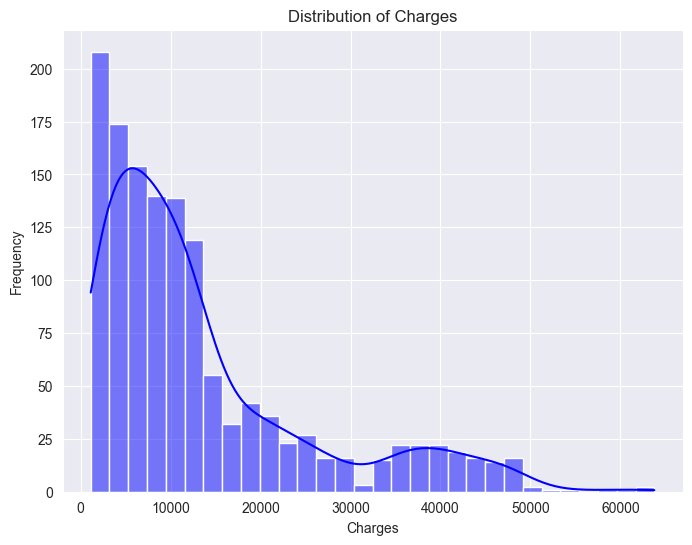

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.histplot(df['charges'], kde=True, color='blue')
plt.title('Distribution of Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

### Box plot of charges by smoker status

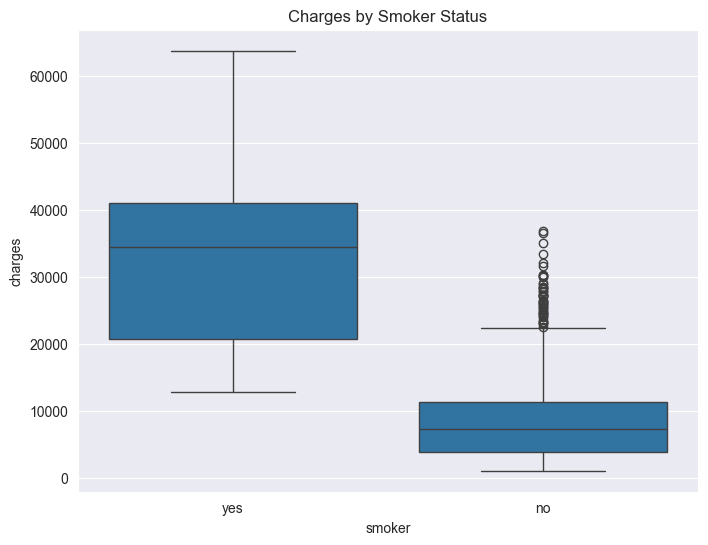

In [6]:
plt.figure(figsize=(8,6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by Smoker Status')
plt.show()

### Check the correlation heatmap

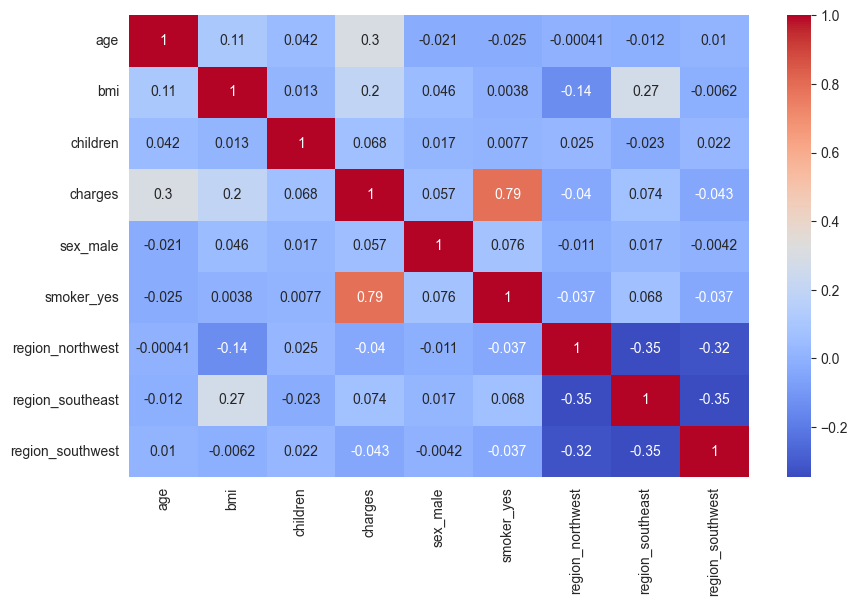

In [21]:
df_encoded = pd.get_dummies(df, drop_first=True)

#Plot the correlation matrix
plt.figure(figsize=(10,6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.show()

### Separate features and target variable

In [8]:
X = df.drop('charges', axis=1)
y = df['charges']

### Prepare the data for modeling

In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Define categorical and numerical columns
categorical_cols = ['sex', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'children']

# Create the ColumnTransformer with OneHotEncoder and StandardScaler
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

# Fit and transform the features
X_preprocessed = preprocessor.fit_transform(X)

# Get feature names after encoding
num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = num_features + list(cat_features)

# Convert the preprocessed features to a DataFrame
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names)

### Split the data into training and testing sets

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed_df, y, test_size=0.2, random_state=42)

### Build and train the Linear Regression model

In [11]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

### Calculate evaluation metrics

In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print('\nModel Evaluation Metrics:')
print('Mean Absolute Error (MAE):', round(mae, 2))
print('Mean Squared Error (MSE):', round(mse, 2))
print('Root Mean Squared Error (RMSE):', round(rmse, 2))
print('R2 Score:', round(r_squared, 4))


Model Evaluation Metrics:
Mean Absolute Error (MAE): 4176.96
Mean Squared Error (MSE): 33568529.3
Root Mean Squared Error (RMSE): 5793.84
R2 Score: 0.7838


### Perform a cross validation using 5-fold cross-validation

In [18]:
from sklearn.model_selection import cross_val_score, KFold

k = 5  # You can choose the number of folds (e.g., 5 or 10)
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation and compute evaluation metrics
cv_results = cross_val_score(model, X_preprocessed, y, cv=kfold, scoring='r2')

# Convert scores to positive values
mae_scores = -cv_results

print(f"Cross-Validation MAE Scores: {mae_scores}")
print(f"Average MAE: {mae_scores.mean():.2f}")
print(f"Standard Deviation of MAE: {mae_scores.std():.2f}")

Cross-Validation MAE Scores: [-0.78359298 -0.7380458  -0.79558615 -0.63243806 -0.75131533]
Average MAE: -0.74
Standard Deviation of MAE: 0.06


### Plot predicted vs actual charges

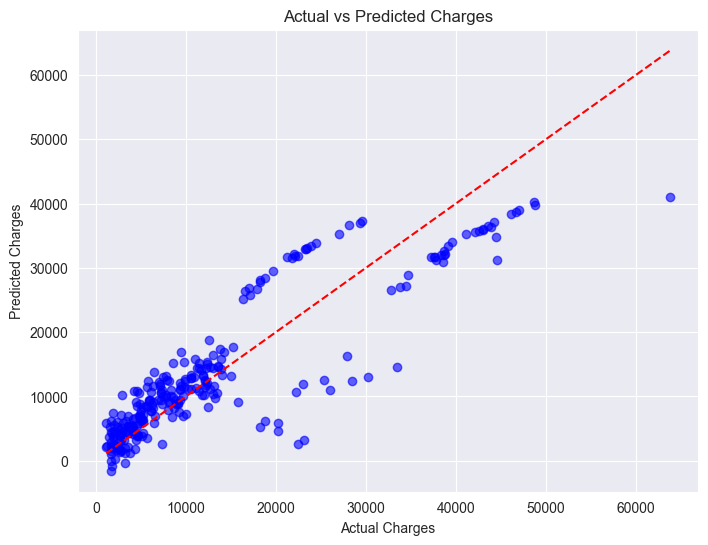

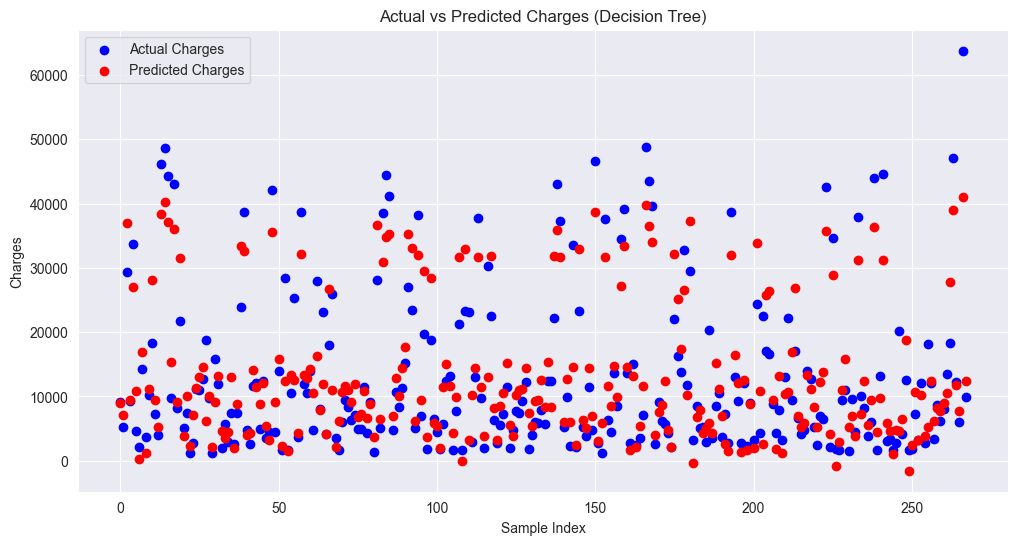

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.show()

###

y_test = y_test.reset_index(drop=True)
y_pred_best_dt = pd.Series(y_pred)

plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Charges')
plt.scatter(range(len(y_pred_best_dt)), y_pred_best_dt, color='red', label='Predicted Charges')
plt.xlabel('Sample Index')
plt.ylabel('Charges')
plt.title('Actual vs Predicted Charges (Decision Tree)')
plt.legend()
plt.show()